In [1]:
import torch
import utils.config as config

from models.basemodel import Network, NetworkMargin

DEVICE = 'cuda:0'
print(config.num_class)
# baseline = NetworkMargin(config.model_name, config.num_class, DEVICE, config.mlp_neurons)
baseline = Network(config.model_name, config.num_class, config.mlp_neurons)
''' Uncomment lines 108-110 only if the ERM trained model is required.'''
model_name = 'basemodel.pth'
with torch.no_grad():
    baseline.load_state_dict(torch.load(os.path.join('./', model_name)))

baseline.eval()
baseline = baseline.to('cuda:0')

1


In [18]:
weight = baseline.classifier.weight
weight.shape

torch.Size([2, 128])

In [3]:
U, S, V = torch.svd(weight)

In [4]:
print(S)
print(S.max()/S.min())

tensor([0.4582, 0.1477], device='cuda:0', grad_fn=<LinalgSvdBackward0>)
tensor(3.1020, device='cuda:0', grad_fn=<DivBackward0>)


In [5]:
S = S / S.sum()

In [6]:
S

tensor([0.7562, 0.2438], device='cuda:0', grad_fn=<DivBackward0>)

In [7]:
import numpy as np
from scipy.stats import entropy

prob_dist = S.detach().cpu().numpy()
entropy_value = entropy(prob_dist, base=2)

print(entropy_value)

0.8012797251033384


In [8]:
U.shape, V.shape

(torch.Size([2, 2]), torch.Size([128, 2]))

In [9]:
margin = NetworkMargin(config.model_name, config.num_class, DEVICE, config.mlp_neurons)
model_name = 'margin.pth'
with torch.no_grad():
    margin.load_state_dict(torch.load(os.path.join('./', model_name)))

margin.eval()
margin = margin.to('cuda:0')

weight_m = margin.weight1

U, S, V_m = torch.svd(weight_m)

V.T @ V_m

reached here


tensor([[-0.0032, -0.1079],
        [ 0.1319,  0.0991]], device='cuda:0', grad_fn=<MmBackward0>)

In [10]:
import torch.nn.functional as F

w1 = V.T
w2 = V_m.T
print(w1.shape[0], w2.shape[0])
for i in range(w1.shape[0]):
    for j in range(w2.shape[0]):
        print(F.cosine_similarity(w1[i], w2[j], dim=-1))

2 2
tensor(-0.0032, device='cuda:0', grad_fn=<SumBackward1>)
tensor(-0.1079, device='cuda:0', grad_fn=<SumBackward1>)
tensor(0.1319, device='cuda:0', grad_fn=<SumBackward1>)
tensor(0.0991, device='cuda:0', grad_fn=<SumBackward1>)


In [8]:
import torch
import utils.config as config

from models.basemodel import Network, NetworkMargin

DEVICE = 'cuda:0'
print(config.num_class)
# baseline = NetworkMargin(config.model_name, config.num_class, DEVICE, config.mlp_neurons)
model_name = 'basemodel1.pth'
baseline = Network(model_name, config.num_class, config.mlp_neurons)
''' Uncomment lines 108-110 only if the ERM trained model is required.'''

with torch.no_grad():
    baseline.load_state_dict(torch.load(os.path.join('./', model_name)))

baseline.eval()
baseline = baseline.to(DEVICE)

1


In [9]:
# weight = baseline.new_feats
# weight = weight[0].weight
weight = baseline.classifier.weight
U, S, V = torch.svd(weight)

In [10]:
U.shape, V.shape, S.shape

(torch.Size([2, 2]), torch.Size([128, 2]), torch.Size([2]))

In [11]:
u = U[0]
v = V[:, 0]
v.shape, S

(torch.Size([128]),
 tensor([0.4582, 0.1477], device='cuda:0', grad_fn=<LinalgSvdBackward0>))

In [12]:
from torch.utils.data import DataLoader
from utils.dataset import CelebaDataset, WaterBirds, WaterBirdsActual

train_dataset = WaterBirds(split='train')
valid_dataset = WaterBirds(split='val')
test_dataset = WaterBirds(split='test')
batch_size = 256
print(len(train_dataset))
train_loader = DataLoader(dataset=train_dataset,
                    batch_size=batch_size,
                    shuffle=False,
                    sampler=None,
                    num_workers=4)

valid_loader = DataLoader(dataset=valid_dataset,
                    batch_size=batch_size,
                    shuffle=False,
                    num_workers=4)

test_loader = DataLoader(dataset=test_dataset,
                    batch_size=batch_size,
                    shuffle=False,
                    num_workers=4)

(532, 512)
(5794, 512)
4795


In [13]:
u = u.squeeze(-1)
v = v.squeeze(-1)

In [14]:
import torch.nn as nn
import numpy as np

v = v / v.norm()

s00, s01, s10, s11 = [], [], [], []
# s0, s1 = [], []
for _, (_, features, targets, z1, _) in enumerate(train_loader):
    features = features.to(DEVICE)
    features = features.float()
    targets = targets.to(DEVICE)
    z1 = z1.to(DEVICE)
    with torch.no_grad():
        # f = features #baseline.model_ft(features)
        # print(f.shape)
        # for i in range(f.shape[0]):
        #     f[i] = f[i] / f[i].norm()
        
        logits, p, f = baseline(features)
        # print(f.shape, v.shape)
        # l = nn.CrossEntropyLoss(reduction='none')(logits, targets.long())
        
        # f00 = l[(targets==0) & ((z1==0))]
        # f01 = l[(targets==0) & ((z1==1))]
        # f10 = l[(targets==1) & ((z1==0))]
        # f11 = l[(targets==1) & ((z1==1))]
        
        # s00.extend((f00).tolist())
        # s01.extend((f01).tolist())
        # s10.extend((f10).tolist())
        # s11.extend((f11).tolist())

        f00 = f[(targets==0) & ((z1==0))]
        f01 = f[(targets==0) & ((z1==1))]
        f10 = f[(targets==1) & ((z1==0))]
        f11 = f[(targets==1) & ((z1==1))]
        
        s00.extend((f00 @ v).tolist())
        s01.extend((f01 @ v).tolist())
        s10.extend((f10 @ v).tolist())
        s11.extend((f11 @ v).tolist())

        # f0 = f[targets==0]
        # f1 = f[targets==1]

        # s0.extend((f0 @ v).tolist())
        # s1.extend((f1 @ v).tolist())

s00 = np.array(s00)
s01 = np.array(s01)
s10 = np.array(s10)
s11 = np.array(s11)

print(s00.mean(), s01.mean(), s10.mean(), s11.mean())
print(s00.std(), s01.std(), s10.std(), s11.std())
# print(sum(s0)/ len(s0), sum(s1)/len(s1))

0.44727871249274925 -0.06308256951160729 0.04182845367384808 -0.43587621076908334
0.18478021243389048 0.24158694669989617 0.2587823190363827 0.1999153640036004


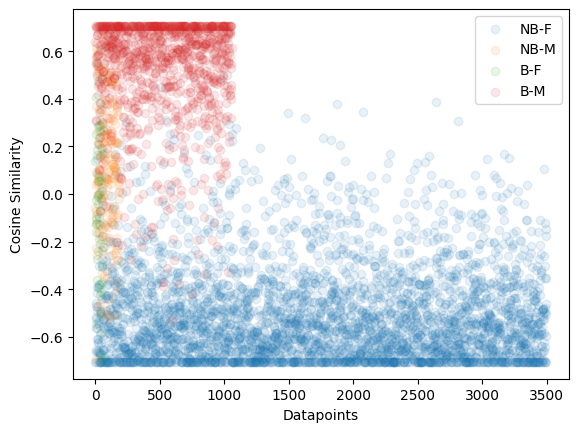

In [8]:
import matplotlib.pyplot as plt

plt.scatter([i for i in range(len(s00))], s00, label='NB-F', alpha=0.1)
plt.scatter([i for i in range(len(s01))], s01, label='NB-M', alpha=0.1)
plt.scatter([i for i in range(len(s10))], s10, label='B-F', alpha=0.1)
plt.scatter([i for i in range(len(s11))], s11, label='B-M', alpha=0.1)

plt.xlabel('Datapoints')
plt.ylabel('Cosine Similarity')
plt.legend()
plt.show()

In [9]:
import torch.nn.functional as F
torch.set_printoptions(precision=4, sci_mode=False)
torch.abs(v)

tensor([    0.0611,     0.0011,     0.0096,     0.0415,     0.0418,     0.0094,
            0.0214,     0.2370,     0.0418,     0.0126,     0.0179,     0.0251,
            0.0157,     0.0051,     0.0137,     0.0355,     0.0273,     0.0993,
            0.0231,     0.0261,     0.0071,     0.0305,     0.0076,     0.0019,
            0.0529,     0.0615,     0.0168,     0.0053,     0.0280,     0.0020,
            0.0056,     0.0937,     0.0203,     0.0248,     0.0103,     0.0334,
            0.0565,     0.0182,     0.0628,     0.1147,     0.0163,     0.0201,
            0.0027,     0.0195,     0.0216,     0.0504,     0.0220,     0.0006,
            0.0812,     0.0449,     0.0172,     0.0334,     0.0241,     0.0269,
            0.0306,     0.0411,     0.1875,     0.0209,     0.0248,     0.0439,
            0.0243,     0.0432,     0.0262,     0.0194,     0.0398,     0.0060,
            0.0247,     0.0031,     0.0477,     0.0126,     0.0425,     0.0547,
            0.0182,     0.0393,     0.01

In [10]:
w = torch.abs(v)
w1 = w/w.max()
print(w1)

tensor([    0.2579,     0.0044,     0.0404,     0.1752,     0.1763,     0.0397,
            0.0902,     1.0000,     0.1763,     0.0530,     0.0754,     0.1058,
            0.0664,     0.0216,     0.0579,     0.1499,     0.1152,     0.4189,
            0.0976,     0.1101,     0.0298,     0.1288,     0.0321,     0.0082,
            0.2233,     0.2597,     0.0709,     0.0223,     0.1179,     0.0085,
            0.0237,     0.3954,     0.0856,     0.1047,     0.0436,     0.1407,
            0.2385,     0.0767,     0.2648,     0.4839,     0.0688,     0.0847,
            0.0115,     0.0823,     0.0912,     0.2126,     0.0927,     0.0025,
            0.3425,     0.1894,     0.0724,     0.1411,     0.1015,     0.1134,
            0.1290,     0.1734,     0.7910,     0.0882,     0.1048,     0.1851,
            0.1027,     0.1822,     0.1105,     0.0820,     0.1677,     0.0255,
            0.1041,     0.0132,     0.2011,     0.0531,     0.1792,     0.2308,
            0.0769,     0.1656,     0.04

In [29]:
F.softmax(w[:], dim=0)

tensor([0.0077, 0.0086, 0.0074, 0.0080, 0.0079, 0.0075, 0.0076, 0.0074, 0.0086,
        0.0085, 0.0075, 0.0074, 0.0074, 0.0074, 0.0074, 0.0080, 0.0083, 0.0080,
        0.0076, 0.0076, 0.0074, 0.0079, 0.0082, 0.0074, 0.0078, 0.0081, 0.0074,
        0.0077, 0.0084, 0.0074, 0.0080, 0.0077, 0.0074, 0.0074, 0.0075, 0.0082,
        0.0091, 0.0080, 0.0075, 0.0075, 0.0078, 0.0074, 0.0077, 0.0087, 0.0074,
        0.0076, 0.0074, 0.0083, 0.0076, 0.0074, 0.0074, 0.0087, 0.0074, 0.0079,
        0.0075, 0.0074, 0.0075, 0.0074, 0.0074, 0.0075, 0.0088, 0.0086, 0.0076,
        0.0074, 0.0074, 0.0079, 0.0074, 0.0083, 0.0074, 0.0076, 0.0075, 0.0074,
        0.0074, 0.0098, 0.0074, 0.0080, 0.0081, 0.0094, 0.0074, 0.0078, 0.0080,
        0.0079, 0.0074, 0.0082, 0.0080, 0.0074, 0.0074, 0.0074, 0.0077, 0.0074,
        0.0090, 0.0075, 0.0074, 0.0078, 0.0088, 0.0074, 0.0091, 0.0074, 0.0084,
        0.0074, 0.0082, 0.0084, 0.0074, 0.0075, 0.0074, 0.0079, 0.0082, 0.0086,
        0.0090, 0.0074, 0.0079, 0.0079, 

/data2/abhipsa/miniconda3/envs/blackbox_env/lib/python3.10/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/data2/abhipsa/miniconda3/envs/blackbox_env/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


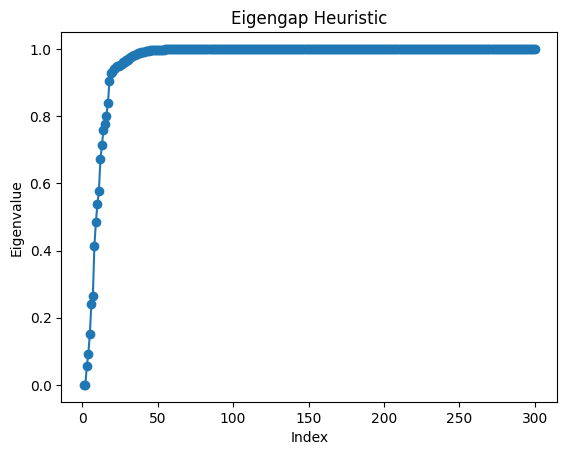

Suggested number of clusters (k): 7


In [10]:
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.cluster import SpectralClustering
from scipy.linalg import eigvals
import matplotlib.pyplot as plt

# Generate sample data
X, _ = make_blobs(n_samples=300, centers=20, cluster_std=0.60, random_state=0)

# Construct the similarity matrix
from sklearn.metrics.pairwise import rbf_kernel
gamma = 0.1  # parameter for RBF kernel
S = rbf_kernel(X, gamma=gamma)

# Compute the degree matrix
D = np.diag(S.sum(axis=1))

# Compute the normalized Laplacian matrix
L = np.identity(len(S)) - np.dot(np.dot(np.diag(1.0 / np.sqrt(D.diagonal())), S), np.diag(1.0 / np.sqrt(D.diagonal())))

# Compute the eigenvalues
eigenvalues = np.sort(eigvals(L))

# Plot the eigenvalues to find the eigengap
plt.plot(np.arange(1, len(eigenvalues) + 1), eigenvalues, marker='o')
plt.title("Eigengap Heuristic")
plt.xlabel("Index")
plt.ylabel("Eigenvalue")
plt.show()

# Determine the eigengap
eigengap = np.diff(eigenvalues)
k = np.argmax(eigengap) + 1
print("Suggested number of clusters (k):", k)